In [3]:
import pandas as pd
import numpy as np

weather_path = "../../data/sa/au_adelaide_act.csv"
total_path = '../../data/intra_day/NSW_2018_2023.csv'

# load and store datasets
weather = pd.read_csv(weather_path, na_values='-99')
total = pd.read_csv(total_path, na_values='-99', parse_dates=['SETTLEMENTDATE'])

Combine date and time to datetime for datasets where this is necessary - all but `total`.

In [4]:
def to_datetime_df(df):
    date = df['date'].astype('str')
    time = df['time'].astype('str').str.pad(4, fillchar='0')
    df['datetime'] = pd.to_datetime(date + time, format = '%Y%m%d%H%M')
    df_d = df.drop(['date', 'time'], axis = 1)
    return df_d

weather_d = to_datetime_df(weather)

Weather data is hourly, so upsample to 30 minute increments and use linear interpolation to fill values.

In [5]:
weather_resample = weather_d.set_index('datetime').resample('30min').asfreq()
weather_interpolate = weather_resample.interpolate()
weather_interpolate.head()

,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2
datetime,,,,,,,
2016-01-01 00:00:00,27.40,3.0,5.0,80.0,19.0,0.0,NaN
2016-01-01 00:30:00,26.10,5.0,5.0,205.0,27.0,0.0,NaN
2016-01-01 01:00:00,24.80,7.0,5.0,330.0,35.0,0.0,NaN
2016-01-01 01:30:00,24.25,5.5,4.5,315.0,49.0,0.0,NaN
2016-01-01 02:00:00,23.70,4.0,4.0,300.0,63.0,0.0,NaN


And join again with total load.

In [10]:
merged = pd.merge(weather_interpolate, total, left_on='datetime',
                  right_on='SETTLEMENTDATE', how='inner', copy=False, validate='1:1')
merged.rename({'load_act': 'total_load', 'SETTLEMENTDATE':'datetime'}, axis=1, inplace=True)
merged.head()

,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2,REGION,datetime,TOTALDEMAND,RRP,PERIODTYPE
0,17.90,6.5,11.5,155.0,60.5,0.0,0.0,NSW1,2018-03-01 00:30:00,7292.21,62.07,TRADE
1,17.70,7.0,11.0,150.0,60.0,0.0,0.0,NSW1,2018-03-01 01:00:00,7044.51,60.35,TRADE
2,17.50,6.5,11.0,155.0,60.5,0.0,0.0,NSW1,2018-03-01 01:30:00,6683.37,57.16,TRADE
3,17.30,6.0,11.0,160.0,61.0,0.0,0.0,NSW1,2018-03-01 02:00:00,6555.82,55.88,TRADE
4,17.15,6.0,9.5,160.0,62.5,0.0,0.0,NSW1,2018-03-01 02:30:00,6439.90,58.19,TRADE


Ensure result is sorted by timestamp.

In [11]:
merged.sort_values(by='datetime', inplace=True)

Plot all columns against timestamp as a sanity check.

array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>], dtype=object)

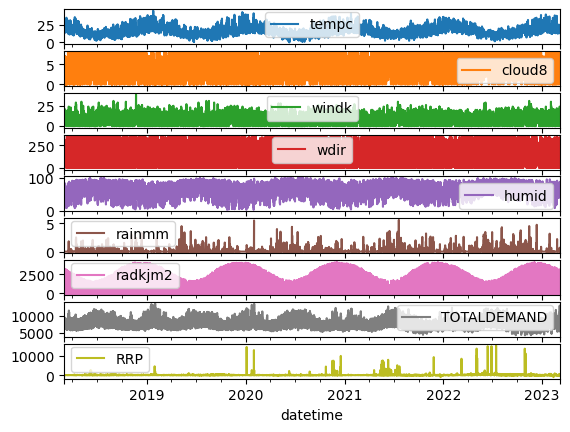

In [12]:
merged.plot(x='datetime', subplots=True)

Write to file.

In [9]:
merged.to_csv('../../data/intra_day/merged_interpolated_NSW.csv', index=False)